In [20]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_percentage_error
from xgboost import XGBRegressor
from matplotlib import pyplot
import numpy as np
import pandas as pd

In [26]:
df = pd.read_csv('Dasatest_N.csv')
df['Month'] = pd.to_datetime(df.Month , format = '%d-%m-%Y')
data_frame = df.drop(['Month'], axis=1)
data_frame.index = df.Month
cols = data_frame.columns
data_frame.index.freq = 'MS'

[0.17823648 0.16549748 0.19075444 0.32173308 0.20312644 0.04834462
 0.18006378 0.17699003 0.22417279 0.2238101  0.07030606 0.31409357
 0.25362672 0.31700699 0.49354767 0.35626946 0.30131239 0.29578345
 0.213944   0.22555971 0.19962786 0.29516055 0.30114212 0.36907415
 0.14887313 0.14864796 0.14128585 0.17659463 0.29808062 0.2476863
 0.07335822 0.16707072 0.3691977  0.27328457 0.16652193 0.23255613
 0.32411527 0.33724036 0.32881964 0.48837095 0.45294321 0.29971693
 0.2768855  0.35326915 0.39137632 0.57588791 0.41283387 0.40444602
 0.31516125 0.41367919 0.43642823 0.4523301  0.3555332  0.3975923
 0.42992231 0.31547104 0.42569258 0.43753179 0.40187582 0.32058841
 0.31055657 0.28562714 0.33198779 0.37764262 0.3849899  0.36292685
 0.23051629 0.26364287 0.29675056 0.40026859 0.36040647 0.33592286]
MAPE: 0.166


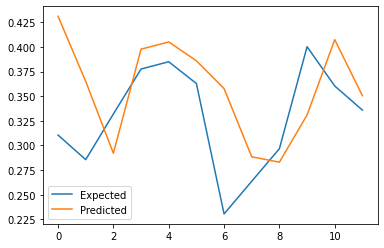

In [55]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# 	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
    train = data
	# split dataset
# 	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
# 		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_percentage_error(test[:, -1], predictions)
	return error, test[:, -1], predictions
 
# load the dataset
series = data_frame.iloc[:,2]
values = series.values
print(values)
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=24,n_out=3)
# evaluate
mape, y, yhat = walk_forward_validation(data, 12)
print('MAPE: %.3f' % mape)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()